## Домашнее задание: рекомендательные системы - 2

## Часть 1: метрики качества рекомендаций

Допишите функцию для вычисления метрики **hitrate @ k**.

Метрика hitrate @ k равна 1, если хотя бы одна из рекомендаций была верной, и 0 иначе.

In [ ]:
def hitrate_at_k(actual, recommended, k):
    """
    Вычисляет метрику Hit Rate @ K.

    Параметры:
    actual (list): Список фактических предпочтений пользователя (список элементов, которые пользователь оценил или использовал).
    recommended (list): Список рекомендованных элементов (список элементов, рекомендованных системой).
    k (int): Количество элементов, учитываемых при вычислении метрики.

    Возвращает:
    hit_rate (float): Значение метрики HitRate @ K.
    """

    # Ограничиваем рекомендации и фактические предпочтения только топ-K элементами
    actual = actual[:k]
    recommended = recommended[:k]

    # Подсчитайте, сколько из рекомендованных элементов присутствует в фактических предпочтениях
    hits = len(set(actual) & set(recommended))

    # Вычислите метрику Hit Rate @ K
    hit_rate = 1 if hits > 0 else 0



    return hit_rate

## Quiz

Пользуясь написанной вами функцией `hitrate_at_k`, вычислите значение метрики для данных:

* actual = [1, 2, 3, 4, 5]
* recommended = [3, 4, 5, 6, 7]
* k = 2


In [ ]:
actual = [1, 2, 3, 4, 5]
recommended = [3, 4, 5, 6, 7]
hits = len(set(actual) & set(recommended))
hits

3

In [ ]:
hitrate_at_k(actual=[1, 2, 3, 4, 5], recommended=[3, 4, 5, 6, 7], k=2)

0

## Quiz

Пользуясь написанной вами функцией `hitrate_at_k`, вычислите значение метрики для данных:

* actual = [1, 2, 3, 4, 5]
* recommended = [3, 4, 5, 6, 7]
* k = 3


In [ ]:
hitrate_at_k(actual=[1, 2, 3, 4, 5], recommended=[3, 4, 5, 6, 7], k=3)

1

Вычислите метрику **DCG @ k** по формуле:
$$DCG @ k = \sum\limits_{i=1}^k \frac{(2^{r_i}-1)}{log_2(p_i+1)},$$
где
* $r_i$ - релевантность элемента на позиции $i$
* $p_i = i + 1$ - позиция элемента (начиная с 1)

In [ ]:
import math

def dcg_at_k(ranking, k):
    """
    Вычисляет метрику DCG (Discounted Cumulative Gain) на основе ранжирования элементов.

    Параметры:
    ranking (list): Список релевантностей элементов в ранжировании.
    k (int): Количество элементов в ранжировании, которые мы анализируем.

    Возвращает:
    float: Значение метрики DCG@k.
    """
    if k <= 0:
        raise ValueError("k должно быть положительным числом")

    # Убедимся, что k не превышает размер ранжирования
    k = min(k, len(ranking))

    dcg = 0.0
    for i in range(k):
        rel = ranking[i]  # Релевантность элемента в позиции i
        position = i + 1  # Позиция элемента (начиная с 1)
        # Вычисляем DCG для элемента в позиции i и добавляем к накопленному DCG
        dcg += (2**rel - 1) / (math.log2(position + 1))

    return dcg

## Quiz

Пользуясь написанной функцией `dcg_at_k`, вычислите значение метрики DCG @ k для:

* relevance = [1, 0, 0, 1, 1, 1, 0, 1] (список релевантностей элементов в ранжировании)
* k = 5

Ответ округлите до сотых.

In [ ]:
dcg_at_k([1, 0, 0, 1, 1, 1, 0, 1], k=5)

1.8175293653079347

## Часть 2: контентные модели для рекомендации фильмов

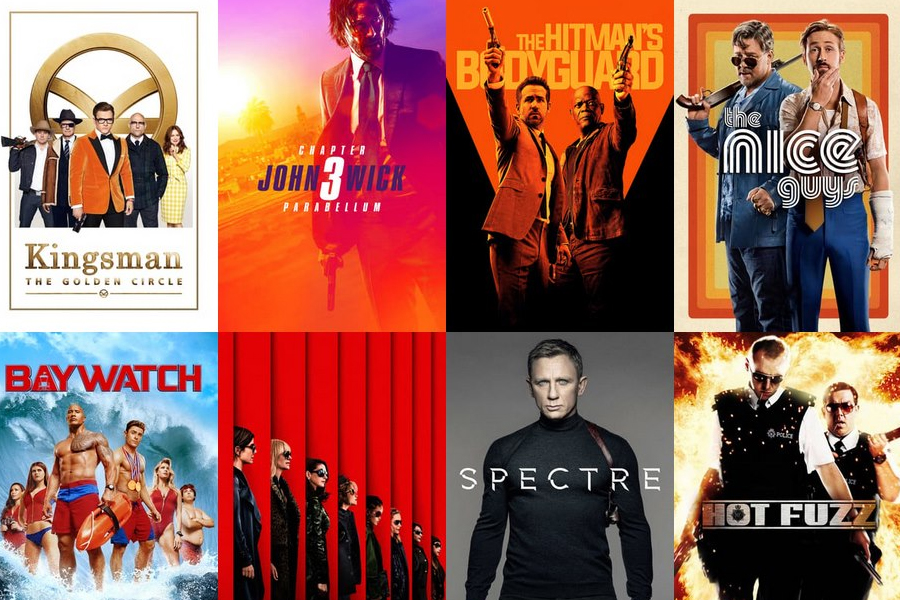

Потренируемся использовать контентный подход для построения рекомендаций.

In [1]:
import pandas as pd

Загрузим данные о пользователях и рейтингах, которые они проставили тем или иным фильмам.

In [2]:
ratings = pd.read_csv("https://raw.githubusercontent.com/aiedu-courses/stepik_applied_tasks/main/datasets/ratings_small.csv")

In [ ]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


Загрузим дополнительную информацию о фильмах.

In [3]:
movies = pd.read_csv("https://raw.githubusercontent.com/aiedu-courses/stepik_applied_tasks/main/datasets/movies_metadata.csv")

movies.head()

<ipython-input-3-d862639473ea>:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movies = pd.read_csv("https://raw.githubusercontent.com/aiedu-courses/stepik_applied_tasks/main/datasets/movies_metadata.csv")


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


## Quiz

Изучите столбец `original_language`. Фильмы на каких трех языках чаще всего встречаются в таблице?

In [ ]:
movies.original_language.value_counts()

en       32269
fr        2438
it        1529
ja        1350
de        1080
         ...  
zu           1
qu           1
104.0        1
la           1
si           1
Name: original_language, Length: 92, dtype: int64

Создадим несколько вспомогательных столбцов, обозначающих язык фильма.

In [4]:
movies['is_eng'] = movies['original_language'].apply(lambda x: 1 if x == 'en' else 0)
movies['is_fr'] = movies['original_language'].apply(lambda x: 1 if x == 'fr' else 0)
movies['is_it'] = movies['original_language'].apply(lambda x: 1 if x == 'it' else 0)
movies['is_ja'] = movies['original_language'].apply(lambda x: 1 if x == 'ja' else 0)
movies['is_de'] = movies['original_language'].apply(lambda x: 1 if x == 'de' else 0)

## Quiz

Изучите столбец `genres`.

Какого из перечисленных жанров нет в данном столбце?

In [ ]:
movies.genres.value_counts()

[{'id': 18, 'name': 'Drama'}]                                                                                                         5000
[{'id': 35, 'name': 'Comedy'}]                                                                                                        3621
[{'id': 99, 'name': 'Documentary'}]                                                                                                   2723
[]                                                                                                                                    2442
[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'name': 'Romance'}]                                                                       1301
                                                                                                                                      ... 
[{'id': 28, 'name': 'Action'}, {'id': 18, 'name': 'Drama'}, {'id': 35, 'name': 'Comedy'}, {'id': 99, 'name': 'Documentary'}]             1
[{'id': 10752, 'name': 'War

In [ ]:
movies.genres.str.contains('FairyTail').any()

False

Создадим вспомогательные столбцы, означающие принадлежность фильма к тем или иным жанрам.

In [5]:
movies['is_animation'] = movies['genres'].apply(lambda x: 1 if x.find('Animation') != -1 else 0)
movies['is_comedy'] = movies['genres'].apply(lambda x: 1 if x.find('Comedy') != -1 else 0)
movies['is_family'] = movies['genres'].apply(lambda x: 1 if x.find('Family') != -1 else 0)
movies['is_action'] = movies['genres'].apply(lambda x: 1 if x.find('Action') != -1 else 0)
movies['is_thriller'] = movies['genres'].apply(lambda x: 1 if x.find('Thriller') != -1 else 0)

Оставьте в таблице `movies` только следующие колонки:
`budget`,`id`,`popularity`,`revenue`,`runtime`,`vote_average`,
`is_eng`,`is_fr`,`is_it`,`is_ja`,`is_de`,
`is_animation`,`is_comedy`,`is_family`,`is_action`,`is_thriller`

In [6]:
movies = movies.loc[:, movies.columns.isin(['budget', 'id', 'popularity', 'revenue', 'runtime', 'vote_average', 'is_eng', 'is_fr', 'is_it', 'is_ja', 'is_de', 'is_animation', 'is_comedy', 'is_family', 'is_action', 'is_thriller'])]

In [ ]:
movies.shape

(45466, 16)

Приведем столбец `movieId` таблицы `ratings` к типу string для дальнейшей склейки.

In [7]:
ratings['movieId'] = ratings['movieId'].astype(str)

Удалим дубли по `id` из таблицы `movies`.

In [8]:
movies = movies.drop_duplicates(subset=['id'])

## Quiz

Сколько строк осталось в таблице `movies` после удаления дублей?

In [9]:
movies.shape

(45436, 16)

Подклеим к таблице `ratings` информацию из таблицы `movies`.

In [10]:
merged_df = pd.merge(ratings, movies, how='left', left_on='movieId', right_on='id')

In [ ]:
merged_df.shape

(100004, 15)

In [ ]:
merged_df.sample(5)

,userId,movieId,rating,timestamp,budget,id,popularity,revenue,runtime,vote_average,is_animation,is_comedy,is_family,is_action,is_thriller
21906,151,590,3.0,847296584,25000000,590,14.686487,41597830.0,114.0,7.0,0.0,0.0,0.0,0.0,0.0
26068,190,2976,5.0,975693787,50000000,2976,7.768045,90450008.0,117.0,6.5,0.0,1.0,1.0,0.0,0.0
25764,188,173,3.0,841064943,5000000,173,8.722406,28200000.0,127.0,6.9,0.0,0.0,0.0,0.0,0.0
98667,662,204,3.0,839022714,0,204,7.643793,0.0,147.0,7.9,0.0,0.0,0.0,0.0,1.0
9678,67,592,3.0,854715905,1600000,592,13.245638,4420000.0,113.0,7.5,0.0,0.0,0.0,0.0,0.0


In [ ]:
merged_df.isna().sum()

userId              0
movieId             0
rating              0
timestamp           0
budget          55015
id              55015
popularity      55015
revenue         55015
runtime         55019
vote_average    55015
is_animation    55015
is_comedy       55015
is_family       55015
is_action       55015
is_thriller     55015
dtype: int64

Заполните `NaN`-значения в таблице `merge_df` значением $-1$.

In [11]:
merged_df = merged_df.fillna(1)

In [ ]:
merged_df.isna().sum()

userId          0
movieId         0
rating          0
timestamp       0
budget          0
id              0
popularity      0
revenue         0
runtime         0
vote_average    0
is_eng          0
is_fr           0
is_it           0
is_ja           0
is_de           0
is_animation    0
is_comedy       0
is_family       0
is_action       0
is_thriller     0
dtype: int64

## Quiz

Удалите из таблицы `merge_df` столбцы `userId` и `movieId`.

Сколько столбцов осталось в таблице?

In [12]:
merged_df.drop(columns=['userId', 'movieId'], inplace=True)

In [13]:
merged_df.shape

(100004, 18)

## Quiz

Разбейте таблицу `merge_df` на `train_df` и `test_df` по условию, что в `train_df` взаимодействия происходят при $timestamp < 1300000000$, а в `test_df` попадают все остальные взаимодействия.

Сколько строк попало в таблицу `test_df`?

In [ ]:
merged_df.head(5)

,rating,timestamp,budget,id,popularity,revenue,runtime,vote_average,is_eng,is_fr,is_it,is_ja,is_de,is_animation,is_comedy,is_family,is_action,is_thriller
0,2.5,1260759144,1,1,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,3.0,1260759179,1,1,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,3.0,1260759182,1,1,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,2.0,1260759185,1,1,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,4.0,1260759205,1,1,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [14]:
train_df = merged_df[merged_df.timestamp < 1_300_000_000]

In [ ]:
train_df.shape

(76635, 18)

In [15]:
test_df = merged_df[merged_df.timestamp >= 1_300_000_000]

In [ ]:
test_df.shape

(23369, 18)

Удалим столбец `timestamp` из `train_df` и `test_df`.

In [16]:
train_df.drop('timestamp', axis=1, inplace=True)
test_df.drop('timestamp', axis=1, inplace=True)

<ipython-input-16-428ceecae158>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.drop('timestamp', axis=1, inplace=True)
<ipython-input-16-428ceecae158>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.drop('timestamp', axis=1, inplace=True)


Создайте объекты:
* `Xtrain` - матрица объект-признак для тренировочной части данных (без столбца `rating`)
* `ytrain` - целевой вектор в тренировочных данных (столбец `rating`)
* Аналогичные объекты `Xtest` и `ytest` для тестовых данных

In [17]:
ytrain = train_df.rating
Xtrain  = train_df.drop(columns='rating')

In [ ]:
Xtrain.shape, ytrain.shape

((76635, 16), (76635,))

In [18]:
ytest = test_df.rating
Xtest  = test_df.drop(columns='rating')

In [ ]:
Xtest.shape, ytest.shape

((23369, 16), (23369,))

## Строим модель

In [19]:
!pip install catboost -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.7 MB/s eta 0:00:00


Обучите catboost с гиперпараметрами по умолчанию на тренировочных данных.

In [24]:
train_df.sample(5)

,rating,budget,id,popularity,revenue,runtime,vote_average,is_eng,is_fr,is_it,is_ja,is_de,is_animation,is_comedy,is_family,is_action,is_thriller
24611,4.0,65000000,861,12.954444,261317921.0,113.0,7.1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
33065,3.0,1,1,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
38815,4.0,0,798,0.076325,0.0,91.0,6.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
16015,4.0,1,1,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
26456,4.0,1,1,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [22]:
from catboost import CatBoostRegressor

model = CatBoostRegressor(verbose=0, random_state=42)
model.fit(Xtrain, ytrain)

## Quiz

Сделайте прогноз на тестовых данных. Вычислите качество прогноза $R^2$.

Ответ округлите до тысячных.

In [23]:
from sklearn.metrics import r2_score

y_pred = model.predict(Xtest)
r2_score(ytest, y_pred)

0.018345725970063675